In [73]:
import numpy as np
import cv2
import math
import matplotlib.pyplot as plt

#cv.imshow() is disabled in colab
from google.colab.patches import cv2_imshow

def scaled_img(img, scale_percent = 300):
  width = int(img.shape[1] * scale_percent / 100)
  height = int(img.shape[0] * scale_percent / 100)
  dim = (width, height)
  return cv2.resize(img, dim, interpolation = cv2.INTER_AREA)

# input: (bot location,destination) output: (direction preset)
def shortest_direction(starting,ending):
  #Remember arctan2 uses usual coord system while np arrays have different coord
  #arctan2(Y-coord,X-coord) from 180 to almost -180
  short_direction = np.arctan2(starting[0]-ending[0],ending[1]-starting[1])
  # short_direction = np.arctan2(0,-1) # Checking boundary values
  short_direction = np.degrees(short_direction)
  #Returning values according to direction preset
  if short_direction < 157.5 and short_direction >= 112.5:
    short_dir_sym = 1
  if short_direction < 112.5 and short_direction >= 112.5:
    short_dir_sym = 2
  if short_direction < 157.5 and short_direction >= 67.5:
    short_dir_sym = 3
  if short_direction < 67.5 and short_direction >= 22.5:
    short_dir_sym = 4
  if short_direction < 22.5 and short_direction >= -22.5:
    short_dir_sym = 5
  if short_direction < -22.5 and short_direction >= -67.5:
    short_dir_sym = 6
  if short_direction < -67.5 and short_direction >= -112.5:
    short_dir_sym = 7
  if short_direction < -112.5 and short_direction >= -157.5:
    short_dir_sym = 7
  if short_direction < -157.5 or short_direction >= 157.5:
    short_dir_sym = 8
  return short_dir_sym

#Input: (Map,current position) Output:( Ascending array [preset,gradient] )
def neighbour_gradient(img,curr_p):
  #Array of gradients of Neighbour
  N_grad = [-99998,0,0,0,0,0,0,0,0]
  N_grad[1] = int( img[curr_p] ) - int( img[ curr_p[0] -1, curr_p[1] -1 ] )
  N_grad[2] = int( img[curr_p] ) - int( img[ curr_p[0] -1, curr_p[1]    ] )
  N_grad[3] = int( img[curr_p] ) - int( img[ curr_p[0] -1, curr_p[1] +1 ] )
  N_grad[4] = int( img[curr_p] ) - int( img[ curr_p[0]   , curr_p[1] +1 ] )
  N_grad[5] = int( img[curr_p] ) - int( img[ curr_p[0] +1, curr_p[1] +1 ] )
  N_grad[6] = int( img[curr_p] ) - int( img[ curr_p[0] +1, curr_p[1]    ] )
  N_grad[7] = int( img[curr_p] ) - int( img[ curr_p[0] +1, curr_p[1] -1 ] )
  N_grad[8] = int( img[curr_p] ) - int( img[ curr_p[0]   , curr_p[1] -1 ] )
  N_grad = [(i, N_grad[i]) for i in range(len(N_grad))]
  N_grad = sorted(N_grad, key=lambda x: x[1],reverse=True)
  return N_grad

#Input: ( current Position, neighbour number ) Output: (location tuple)
def neighbour_location(curr_p,neighbour):
  if(neighbour == 1):
    return ( curr_p[0] -1, curr_p[1] -1 )
  elif (neighbour == 2):
    return ( curr_p[0] -1, curr_p[1]    )
  elif (neighbour == 3):
    return ( curr_p[0] -1, curr_p[1] +1 )
  elif (neighbour == 4):
    return ( curr_p[0]   , curr_p[1] +1 )
  elif (neighbour == 5):
    return ( curr_p[0] +1, curr_p[1] +1 )
  elif (neighbour == 6):
    return ( curr_p[0] +1, curr_p[1]    )
  elif (neighbour == 7):
    return ( curr_p[0] +1, curr_p[1] -1 )
  elif (neighbour == 8):
    return ( curr_p[0]   , curr_p[1] -1 )

def map_range(value, old_min, old_max, new_min, new_max):
    old_range = old_max - old_min
    new_range = new_max - new_min
    new_value = (((value - old_min) * new_range) / old_range) + new_min
    return new_value

#Potential Field Gradient Operator
def window_PFG(img,destination,enable_window,div = 20,ending_grad_range= 127,local_grad_range=30):
  Floor2 =  np.zeros(img.shape,np.uint8)
  max_range = math.dist( [img.shape[0],0],  [0,img.shape[1]])
  for i in range(img.shape[0]-1):
    for j in range(img.shape[1]-1):
      img_coord = (i,j)
      points_difference = math.dist(destination, img_coord) # Distance formula
      px_value = map_range(points_difference,0,max_range,0,ending_grad_range)
      if(enable_window==True):
        for k in range( int( (img.shape[0]-1) /div) ):
          if(px_value == 255):
                break
          for l in range(int( (img.shape[1]-1) /div) ):
            if(px_value == 255):
                break
            itrx =  int( img_coord[0] - (img.shape[0]-1) /(div*2)) + k
            itry = int( img_coord[1] - (img.shape[1]-1) /(div*2)) + l
            if(itrx>=0 and itry>=0 and itrx<img.shape[0] and itry<img.shape[1]):
              if(img[i,j] != 255 and img[itrx,itry] == 255):
                points_difference = math.dist((itrx , itry ), img_coord)
                px_value = px_value+ map_range(points_difference,0,max_range,0,local_grad_range)

      if(px_value > 255):
        px_value = 255
      Floor2[i,j] = px_value
  cv2_imshow((scaled_img(Floor2)))
  return Floor2


In [74]:

# Direction Preset
# a  b  c   ->    1   2   3
# h  *  d   ->    8   *   4
# g  f  e   ->    7   6   5
#Control parameters
image_file = "/content/drive/MyDrive/PathPlanning/original4.png"
div = 20 # Dividing factor for Window size for local gradient -> Window = img/div
local_grad_range = 40
ending_grad_range = 127
starting = (15,85) #for og3 (35,70)#for og1: (25,85) # (x,y)
ending = (85,15) #for og3 (75,25)# for og1:(75,15) # (x,y)
obstacle_dilate_size = (7,7) #dilate should be greater than blur
blur_size = (3,3)
end_size = 2 #actual size would be x2 added e.g for size = 2 -> 2x2+1 =5
start_size = 1 #actual size would be x2 added

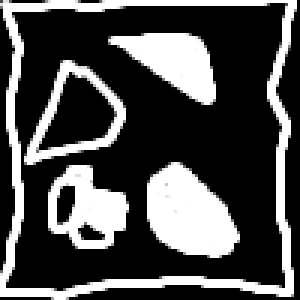

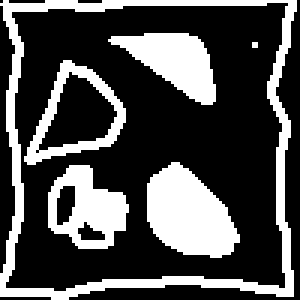

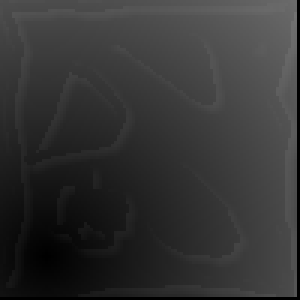

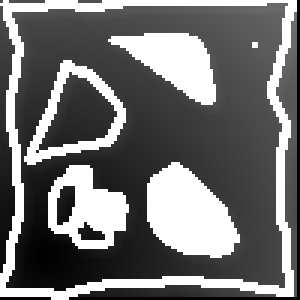

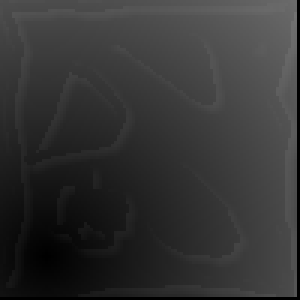

In [75]:
# one block is 1 m^2
# Floor = np.zeros([100,100],np.uint8) #sample empty Floor
Floor = cv2.imread(image_file,0) #0 for grayscale
Floor = cv2.bitwise_not(Floor) #negative image
#increase obstacle size
# kernel = np.ones(obstacle_dilate_size,np.uint8)
# Floor = cv2.dilate(Floor,kernel,iterations = 1)
cv2_imshow((scaled_img(Floor)))

_, Floor = cv2.threshold(Floor, 127, 255, cv2.THRESH_BINARY)
obstacles_map = np.copy(Floor)
# Redundant: #Increasing Ground value
# Floor[np.where(Floor == [0])] = [128]
#Adding start and end location blocks
Floor[ starting[0]-start_size: start_size+starting[0], starting[1]-start_size: start_size+starting[1] ] = 255
Floor[ ending[0]-end_size: end_size+ending[0], ending[1]-end_size: end_size+ending[1] ] = 0
cv2_imshow((scaled_img(Floor)))

operated_img = window_PFG( Floor, ending, True, div, ending_grad_range, local_grad_range )
op1 = cv2.add(Floor,operated_img)
cv2_imshow((scaled_img(op1)))
cv2.blur(op1,blur_size) #Bluring to acheive gradient
cv2_imshow((scaled_img(operated_img)))


end_point: 90


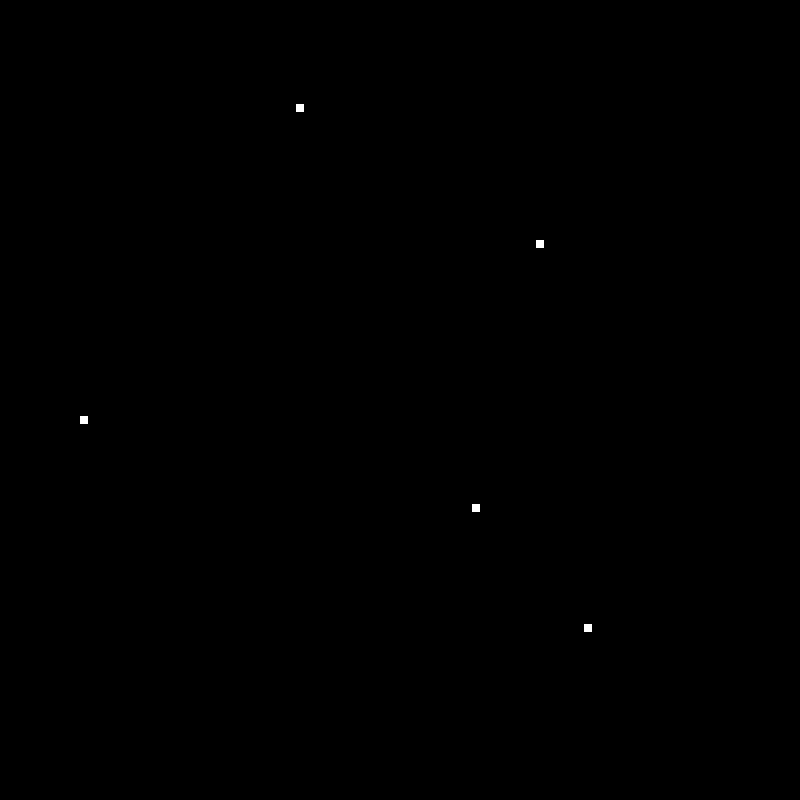

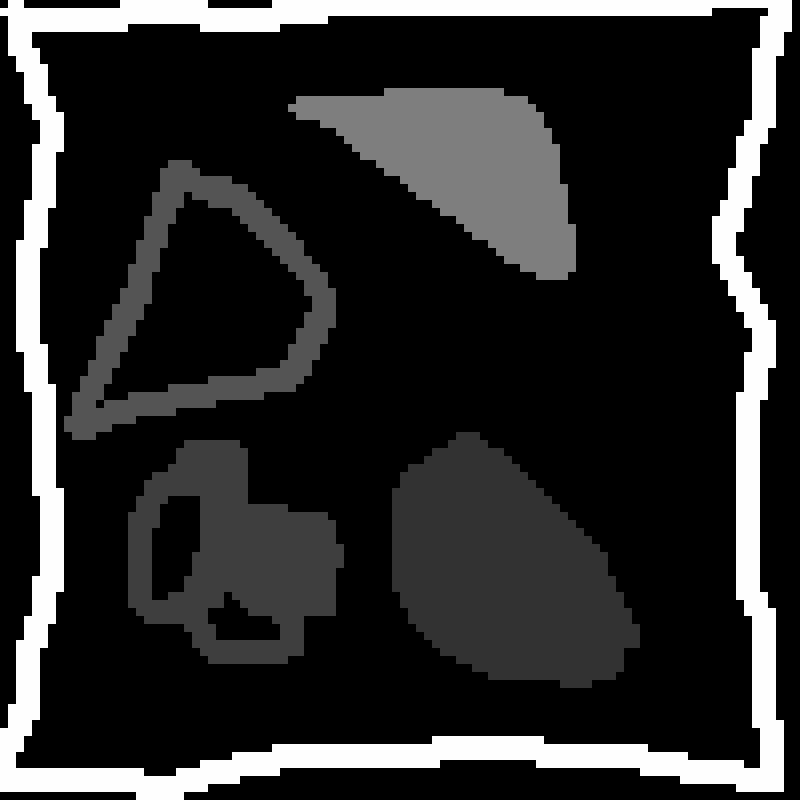

->    6
->    [[0 1 1 ... 1 1 0]
 [1 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 ...
 [1 1 1 ... 1 0 0]
 [1 1 1 ... 1 0 0]
 [0 0 0 ... 0 0 0]]
->    [[   0    0  100  100 6987]
 [   0    0   99  100 1132]
 [  36   11   36   24  457]
 [   8   20   34   35  319]
 [  16   55   27   28  437]
 [  49   54   31   32  668]]
->    [[50.40704165 48.39144125]
 [47.89664311 51.12720848]
 [57.8380744  20.01750547]
 [24.36990596 38.38244514]
 [28.91533181 69.09839817]
 [62.49251497 70.99550898]]


In [93]:
#### Finding End points of Obstacle

#Making skeleton
skeleton = cv2.ximgproc.thinning(obstacles_map, None, 1)
# cv2_imshow((scaled_img(skeleton,800)))
end_line_map = np.copy(skeleton)
# end_line_map[np.where(end_line_map == [0])] = 0
end_line_map[np.where(end_line_map == [255])] = 10
kernel = np.array([ [-1, -1, -1],
                    [-1, 10, -1],
                    [-1, -1, -1]])
end_line_map = cv2.filter2D(end_line_map, -1, kernel)
end_point = np.amax(end_line_map)
print("end_point:",end_point)
end_line_map[np.where(end_line_map == [end_point])] = 255
_, end_line_map = cv2.threshold(end_line_map, 254, 255, cv2.THRESH_BINARY)
cv2_imshow((scaled_img(end_line_map,800)))





# Apply the Component analysis function
analysis = cv2.connectedComponentsWithStats(obstacles_map, 4, cv2.CV_32S)
(totalLabels, label_ids, values, centroid) = analysis
temp = np.zeros_like(Floor)
ccl = label_ids.astype(np.uint8)
# 0 is background
for i in range(1,totalLabels):
  ccl[np.where(label_ids == [i])] = int((255-i)/i)
# ccl[np.where(label_ids == [1])] = [150]
# ccl[np.where(label_ids == [2])] = [255]
# ccl[np.where(label_ids == [3])] = [200]
cv2_imshow((scaled_img(ccl,800)))

print("->   ", totalLabels)
print("->   ", label_ids)
print("->   ", values)
print("->   ", centroid)

# Initialize a new image to
# store all the output components
# output = np.zeros(gray_img.shape, dtype="uint8")

In [94]:
#Path Finding Using Gradient Descent
Path=[]
current_coordinate = starting
i = 1
while(current_coordinate!=ending):
  temp = neighbour_gradient(operated_img,current_coordinate)
  temp = temp[0]
  next_coordinate = neighbour_location(current_coordinate,temp[0])
  Path.append(next_coordinate)
  current_coordinate = next_coordinate
  i = i+1
  if(i==10000):
    print("Error: Cannot reach the destination")
    break


Error: Cannot reach the destination


In [95]:
#Shortest path with obstacle following
Bug1 = []
img = Floor
goal = ending
current_point = starting
i = 1
while(current_point != goal):
  N_number = shortest_direction(current_point,goal)
  next_point = neighbour_location(current_point,N_number)
  #Move CW/CCW with obstacles (2 functions)

  while(img[next_point] == 255):
    #Move CCW:
    N_number = N_number - 1
    if(N_number<1):
      N_number = 8
    next_point = neighbour_location(current_point,N_number)
  Bug1.append(next_point)
  current_point = next_point
  i = i+1
  if(i==10000):
    print("Error: Cannot reach the destination")
    print(Bug1)
    break

[(16, 84), (17, 83), (18, 82), (19, 81), (20, 80), (21, 79), (22, 78), (23, 77), (24, 76), (25, 75), (26, 74), (27, 73), (28, 72), (29, 72), (30, 72), (31, 72), (32, 72), (33, 72), (34, 71), (35, 70), (36, 69), (37, 68), (38, 67), (39, 66), (40, 65), (41, 64), (42, 63), (43, 62), (44, 61), (45, 60), (46, 59), (47, 58), (48, 57), (49, 56), (50, 55), (51, 54), (52, 53), (53, 52), (54, 51), (55, 50), (56, 49), (57, 48), (58, 47), (59, 46), (60, 45), (61, 44), (62, 43), (63, 42), (64, 41), (65, 42), (66, 42), (67, 42), (68, 43), (69, 43), (70, 43), (71, 42), (72, 42), (73, 42), (74, 42), (75, 42), (76, 42), (77, 41), (77, 40), (77, 39), (77, 38), (78, 38), (79, 38), (80, 38), (81, 38), (82, 37), (82, 36), (83, 35), (83, 34), (83, 33), (83, 32), (83, 31), (83, 30), (83, 29), (83, 28), (83, 27), (83, 26), (83, 25), (83, 24), (83, 23), (83, 22), (83, 21), (83, 20), (83, 19), (84, 18), (84, 17), (85, 16), (85, 15)]


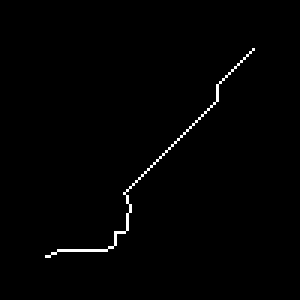

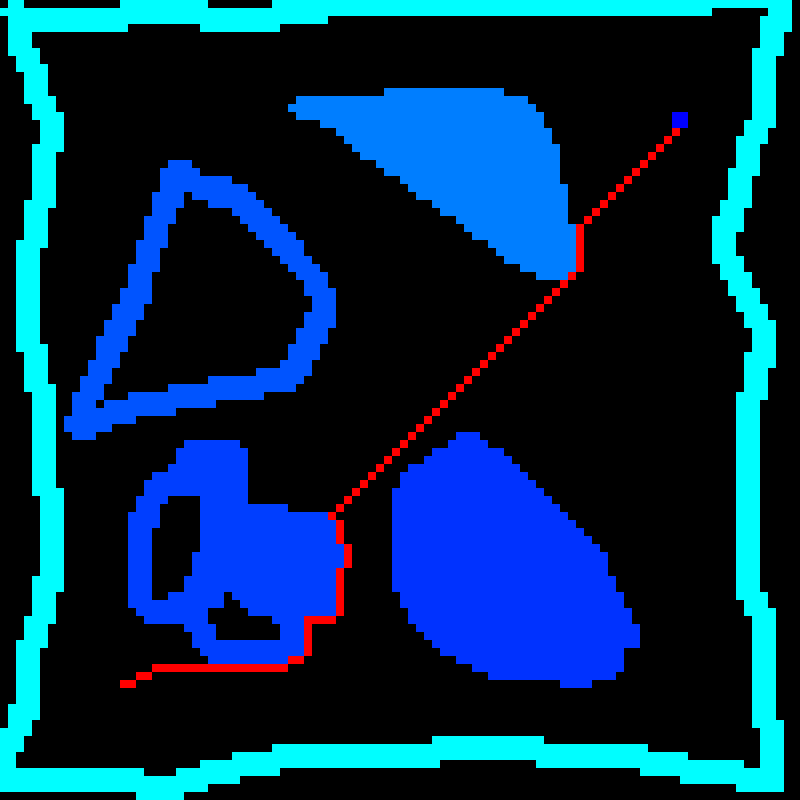

In [96]:
Path = Bug1
Path_map =  np.zeros(Floor.shape,np.uint8)
print(Path)
for i in Path:
  Path_map[i] = 255
cv2_imshow(scaled_img(Path_map))
zeros = np.zeros_like(Floor)
# #Debug_line:
# zeros[38,47] = 255
# zeros[37,48] = 140
#skeleton, end_line_map, ccl
zeros = ccl
colored_image = cv2.merge((Floor, zeros, Path_map))
cv2_imshow(scaled_img(colored_image,800))
#Problem: It will loop itself as soon as it finds the shortest path
#Finding endings of obstacles and CCL labeling is important

# # Sample plot for later use
# x_val = [x[0] for x in Path]
# y_val = [x[1] for x in Path]
# plt.plot(x_val, y_val)
# plt.show()

In [7]:
len(Path)

9999